Missing Values:
 crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

Missing Values After Simulation:
 crim       25
zn         25
indus      25
chas        0
nox         0
rm          0
age         0
dis         0
rad         0
tax         0
ptratio     0
b           0
lstat       0
medv        0
dtype: int64


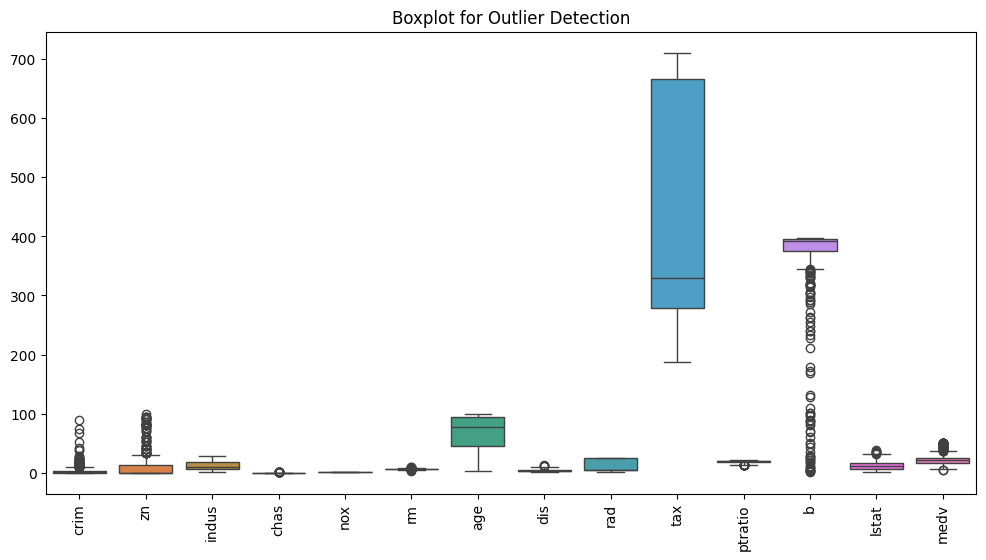

LinearRegression - MSE: 12.40, R2: 0.75
Ridge - MSE: 12.77, R2: 0.74
Lasso - MSE: 13.04, R2: 0.73
RandomForest - MSE: 6.28, R2: 0.87


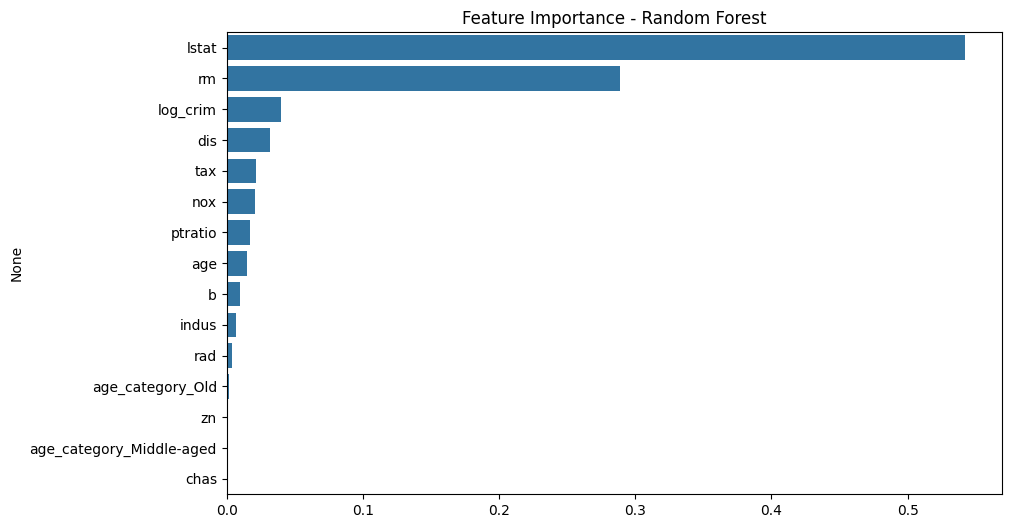

Best Hyperparameters for Ridge: {'alpha': 0.01}
Best R2 Score: 0.7612336228624895


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the Sample Dataset (Housing Prices Dataset)
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
data = pd.read_csv(url)

# Display the first few rows
data.head()

# =========================================================
# 2. Handling Missing Data
# =========================================================
# Check for missing values
print("Missing Values:\n", data.isnull().sum())

# Since there are no missing values in this dataset, let's simulate some
np.random.seed(42)
for col in ['crim', 'zn', 'indus']:
    data.loc[data.sample(frac=0.05).index, col] = np.nan

print("\nMissing Values After Simulation:\n", data.isnull().sum())

# Impute missing values with Mean for numerical columns
data.fillna(data.mean(), inplace=True)

# =========================================================
# 3. Outlier Analysis & Treatment
# =========================================================
# Visualize Outliers using Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.title("Boxplot for Outlier Detection")
plt.show()

# Treat Outliers using IQR Method
for col in data.select_dtypes(include=[np.number]).columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])

# =========================================================
# 4. Feature Engineering
# =========================================================
# Add a new feature: 'Age Category' based on 'age'
data['age_category'] = pd.cut(data['age'], bins=[0, 50, 80, 100], labels=['Young', 'Middle-aged', 'Old'])

# Log Transformation for skewed features (e.g., 'crim')
data['log_crim'] = np.log1p(data['crim'])

# Drop redundant columns
data.drop(columns=['crim'], inplace=True)

# =========================================================
# 5. Splitting Data into Train and Test
# =========================================================
X = data.drop(columns=['medv'])  # Target variable is 'medv'
y = data['medv']

# One-Hot Encoding for categorical features
X = pd.get_dummies(X, drop_first=True)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =========================================================
# 6. Model Training & Evaluation
# =========================================================
# Define models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

# =========================================================
# 7. Feature Importance (Random Forest)
# =========================================================
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Plot Feature Importance
importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importance - Random Forest")
plt.show()

# =========================================================
# 8. Cross-Validation for Model Improvement
# =========================================================
# Hyperparameter tuning for Ridge Regression
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters for Ridge:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)
